In [5]:
from typing import Any, List, Literal, Tuple, cast
from dataclasses import dataclass
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from data import SCRAPED_STOCK_FILE_PATH
import logging
from gsp.model.utils import (
    get_minimal_stocks_existence_date,
    get_nth_previous_working_date,
    show,
)
from sklearn.compose import ColumnTransformer
from sklearn.multioutput import RegressorChain
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor

logger = logging.getLogger(__name__)

YEARS_BACK_TO_CONSIDER = 5
N_STEP_PREDICTION = 30

stocks =  pd.read_csv(
    SCRAPED_STOCK_FILE_PATH,
    dtype={
        "Date": "period[D]",
        "Open": "float",
        "High": "float",
        "Low": "float",
        "Close": "float",
        "Volume": "int",
        "Area": "category",
        "Name": "category",
    },
)

periods = pd.date_range(
    start=stocks["Date"].min().to_timestamp().date(), 
    end=stocks["Date"].max().to_timestamp().date(), 
    freq="B"
)
periods_df = pd.DataFrame({"Date": periods}, dtype="period[D]")
diff_periods = periods_df[~periods_df["Date"].isin(stocks["Date"])]
# show("Missing working holidays days: ",diff_periods)

cleaned = (cast(
    pd.DataFrame,
    periods_df.set_index("Date")
    .join(stocks.set_index("Date"))
    .set_index("Name", append=True)
    .sort_index()
    .unstack("Name")
    .ffill()
    .stack("Name", future_stack=True)) # type: ignore
    .reset_index()
    .dropna(subset=["Name"])
    .set_index(["Date", "Name"])
)

stocks_pre_processed = cleaned.copy()
stocks_pre_processed["DayOfWeek"] = stocks_pre_processed.index.get_level_values("Date").dayofweek
stocks_pre_processed["Month"] = stocks_pre_processed.index.get_level_values("Date").month
stocks_pre_processed["Year"] = stocks_pre_processed.index.get_level_values("Date").year
stocks_pre_processed["Quarter"] = stocks_pre_processed.index.get_level_values("Date").quarter
stocks_pre_processed["NameCat"] = stocks_pre_processed.index.get_level_values("Name").astype("category")

most_recent_date = cast(datetime.date, stocks_pre_processed.index.get_level_values("Date").max().to_timestamp().date())
earliest_considerable_date = get_nth_previous_working_date(YEARS_BACK_TO_CONSIDER * 261, most_recent_date)
all_existence_date = get_minimal_stocks_existence_date(stocks)

least_recent_date = max(earliest_considerable_date, all_existence_date)

# show(
#     f"most_recent_date: {most_recent_date}",
#     f"earliest_considerable_date: {earliest_considerable_date}",
#     f"all_existence_date: {all_existence_date}",
#     f"least_recent_date: {least_recent_date}",
# )

# filter stocks_limited if you want to solve for single problem
stocks_limited = stocks_pre_processed.loc[least_recent_date.isoformat() : most_recent_date.isoformat()]

@dataclass
class ColumnTransformerWrapper:
    transformers: List[Tuple[str, Any, List[str]]]
    remainder: Literal["drop", "passthrough"] = "passthrough"

    def fit_transform(self, X: pd.DataFrame, y: Any | None = None) -> pd.DataFrame:  # type: ignore
        ct = ColumnTransformer(self.transformers, remainder=self.remainder)

        return pd.DataFrame(
            ct.fit_transform(X, y),  # type: ignore
            index=X.index,
            columns=[col.replace("remainder__", "") for col in ct.get_feature_names_out()],
        )


ctw = ColumnTransformerWrapper(
    transformers=[
        ("one_hot", OneHotEncoder(drop="first", sparse_output=False), ["DayOfWeek","NameCat", "Month", "Year", "Quarter", "Area"]),
    ],
    remainder="passthrough",
)

X_encoded = ctw.fit_transform(stocks_limited)

X = X_encoded.drop(columns=["Close", "Adj Close", "Open", "High","Low", "Volume"])

def make_shift_in_groups(
    df: pd.DataFrame,
    groupby: List[str] = [],
    column: str = "",
    shift: List[int] | int = 1,
    name: str | None = None,
) -> pd.DataFrame:
    df = df.copy(deep=True)
    if name is None:
        name = column

    if isinstance(shift, int):
        shift = [shift]

    shift = list(filter(lambda el: el != 0, shift))

    if len(shift) == 0:
        raise ValueError("Shift value must be non-zero!")

    def create_shifted_columns(group):
        shifted_group = pd.DataFrame(index=group.index)
        for val in shift:

            shifted_group[f"{name}_{'lead' if val < 0 else 'lag'}_{abs(val)}"] = group[column].shift(val)

        return shifted_group

    shifted_df = cast(
        pd.DataFrame,
        df
        .groupby(groupby, observed=True, group_keys=False)
        .apply(create_shifted_columns, include_groups=False)
        .sort_index(),
    )

    return shifted_df


y = make_shift_in_groups(df=stocks_limited, groupby=["Name"], column="Close",shift=[-i for i in range(1, N_STEP_PREDICTION+1)])

y, X = y.align(X.dropna(), axis=0, join="inner")

start_training_date = least_recent_date
end_training_date = get_nth_previous_working_date(n=3*N_STEP_PREDICTION, date=most_recent_date)
start_testing_date = get_nth_previous_working_date(n=-N_STEP_PREDICTION, date=end_training_date)
end_testing_date = get_nth_previous_working_date(n=N_STEP_PREDICTION, date=most_recent_date)


# show(
#     f"start_training_date: {start_training_date}",
#     f"end_training_date: {end_training_date}",
#     f"start_testing_date: {start_testing_date}",
#     f"end_testing_date: {end_testing_date}",
# )


X_train = X_encoded.loc[start_training_date.isoformat() : end_training_date.isoformat()]
y_train = y.loc[start_training_date.isoformat() : end_training_date.isoformat()]
X_test = X_encoded.loc[start_testing_date.isoformat() : end_testing_date.isoformat()]
y_test = y.loc[start_testing_date.isoformat() : end_testing_date.isoformat()]

hyper_params = {}
model = RegressorChain(XGBRegressor(**hyper_params))
logger.info("Training the model...")
model.fit(X_train, y_train)
logger.info("Model trained successfully")

y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

y_latest = y_pred.loc[y_pred.index.get_level_values("Date").max().to_timestamp().date().isoformat():]


def convert_to_output(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy(deep=True)
    last_date = df.index.get_level_values("Date").max().to_timestamp().date()

    df_renamed = df.rename(
        columns={
            f"Close_lead_{i}": get_nth_previous_working_date(n=-i, date=last_date)
            for i in range(1, N_STEP_PREDICTION + 1)
        }
    )
    df_melted = (
        df_renamed.reset_index("Name")
        .melt(id_vars=["Name"], var_name="Date", value_name="Close")
        .astype({
            "Date": "period[D]",
            "Name": "category",
            "Close": "float",
        })
        .set_index(["Date","Name"])
    )

    return df_melted


y_output = y_latest.groupby("Name", observed=True, group_keys=False).apply(convert_to_output).sort_index()

INFO __main__ 14:50:31 | Training the model...
INFO __main__ 14:50:36 | Model trained successfully


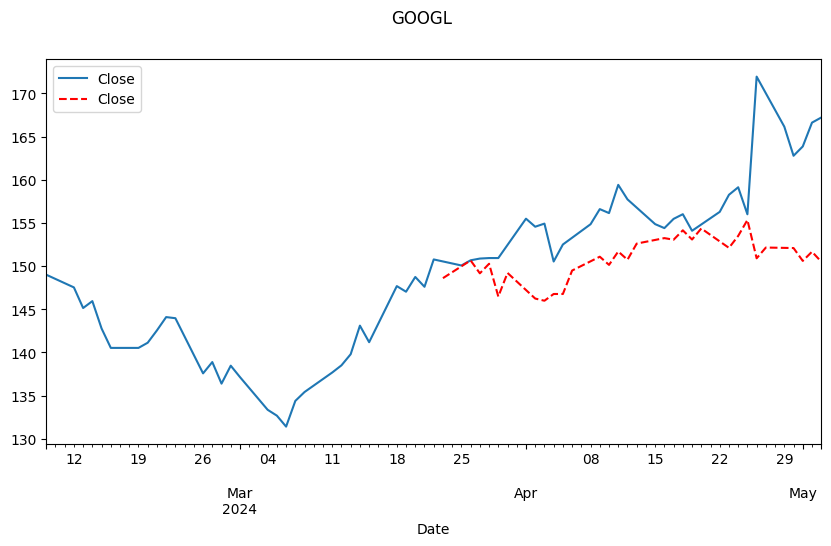

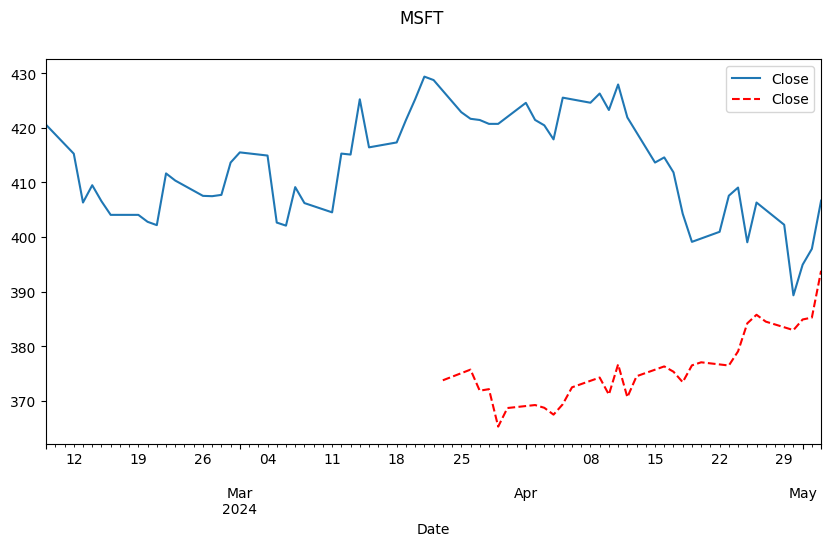

In [16]:
stocks_ids = stocks_limited.index.get_level_values("Name").unique()

for stock_id in stocks_ids:
    fig = plt.figure(figsize=(10, 5))
    fig.suptitle(stock_id)
    stocks_limited.loc[ (stocks_limited.index.get_level_values("Date") >= start_testing_date.isoformat()) & (stocks_limited.index.get_level_values("Name") == stock_id)][["Close"]].reset_index("Name", drop=True).plot(
        ax=fig.gca(), legend=True
    )
    y_output.loc[y_output.index.get_level_values("Name") == stock_id][["Close"]].reset_index("Name",drop=True).plot(
        ax = fig.gca(),
        legend = True,
        style="--",
        color="red"
    )
    plt.show()